In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
from torchmetrics import MeanSquaredError
import os

import segmentation_models_pytorch as smp

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

from Libraries.unet3d import UNet

import os
from PIL import Image
from IPython.display import display
import open3d as o3d

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Functions 
def CreatePointCloud(color_im, depth_im):
    color_raw = o3d.geometry.Image(np.uint8(color_im))
    depth_raw = o3d.geometry.Image(np.float32(depth_im))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, 1000) # 
    PointCloud = o3d.geometry.PointCloud.create_from_rgbd_image(
      rgbd_image,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)) # Creates Point Cloud from rgbd image
#     PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def CreateAxisCloud(depth_im):
    depth_raw  = o3d.geometry.Image(np.float32(depth_im/1)) # Converts depth data into image format
    PointCloud = o3d.geometry.PointCloud.create_from_depth_image(depth_raw,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def pick_points(pcd):
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    numpy_array=np.asarray(pcd.points)
    point_id=vis.get_picked_points()

    return [numpy_array[point_id[0]],numpy_array[point_id[1]]]

def draw_arrow(pcd, points_real, points_extimated):
    lines=[[0,1],[2,3]]
    points = np.concatenate((points_real, points_extimated), axis=0)
    colors = [[1,0,0],[0,1,0]] # Red is REAL and Green is ESTIMATED
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),

    )
    line_set.colors=o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd,line_set])

In [3]:
# Transformations

class GaussianNoise(object):
    def __init__(self, p=0.5, mean=[0.0, 0.5], std=[1.0, 1.0]):
        self.p    = p
        self.std  = np.random.uniform(std[0],std[1])
        self.mean = np.random.uniform(mean[0],mean[1])
        
    def __call__(self, tensor):
        if random.random() < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            return tensor 


DataAug = transforms.Compose([
    transforms.ColorJitter(
        brightness=[0.5,1.5],
        contrast=[0.5, 1.5],
        saturation=[0.5, 1.5],
        hue=[-0.1,0.1],
    ),
    transforms.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 9.0)
    ),
#     transforms.RandomErasing(
#         p=0.1,
#         scale=(0.01, 0.1),
#         ratio=(0.01, 3.3),
#         value=0,
#     ),
    GaussianNoise(
        p=0.2,
        mean=[0.0, 0.1],
        std=[0.01, 0.3]
    )
])

In [4]:
from Libraries.dataloader import DataLoader as DL

DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DL()

X_A, y_A = dl.load(DATASET_ROOTDIR, 'files/data.csv', 'files/axis', 'S')
X_B, y_B = dl.load(DATASET_ROOTDIR, 'files_ArUco/data_ArUco.csv', 'files_ArUco/axis', 'S')

X_trainA, X_validationA, y_trainA, y_validationA = train_test_split(X_A, y_A, test_size=0.2, random_state=101)
X_trainB, X_validationB, y_trainB, y_validationB = train_test_split(X_B, y_B, test_size=0.03, random_state=101)

X_train = torch.cat((X_trainA, X_trainB),axis=0)
y_train = torch.cat((y_trainA, y_trainB),axis=0)

# X_train_aug = X_train.clone()
# for i in range(X_train_aug.shape[0]):
#      X_train_aug[i] = DataAug(X_train_aug[i])
        
# X_train = torch.cat((X_train, X_train_aug),axis=0)
# y_train = torch.cat((y_train, y_train),axis=0)

X_validation = torch.cat((X_validationA, X_validationB),axis=0)
y_validation = torch.cat((y_validationA, y_validationB),axis=0)

In [5]:
X_train.shape 

torch.Size([501, 3, 256, 320])

In [6]:
X_validation.shape

torch.Size([43, 3, 256, 320])

In [7]:
from Libraries.dataloader import DataLoader as DL

DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DL()

X, y = dl.load(DATASET_ROOTDIR, 'files/data.csv', 'files/axis', 'S')

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=101)

X_train_aug = X_train.clone()
for i in range(X_train_aug.shape[0]):
     X_train_aug[i] = DataAug(X_train_aug[i])
        
X_train = torch.cat((X_train, X_train_aug),axis=0)
y_train = torch.cat((y_train, y_train),axis=0)

X_test, y_test = dl.load(DATASET_ROOTDIR, 'files_Test/data_Test.csv', 'files_Test/axis', 'S')


In [8]:
y_train.shape

torch.Size([248, 1, 256, 320])

In [9]:
val_set = TensorDataset(X_validation, y_validation)
train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)

loader_args = dict(batch_size=6, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
train_loader = DataLoader(train_set,shuffle=True, **loader_args)
val_loader = DataLoader(val_set,shuffle=False, **loader_args)
test_loader = DataLoader(test_set,shuffle=False, **loader_args)

In [10]:
device = 'cuda'

In [11]:
ModelCutter = smp.Unet(in_channels=4, classes=1, encoder_weights=None, encoder_name='timm-resnest50d').to(device)
# ModelCutter = UNet(n_channels=4, n_classes=1, width_multiplier=1, trilinear=True, use_ds_conv=False).to(device)

In [12]:
class InpaintLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, out, gt, mask):
        out = torch.mul(out, mask.view(out.shape))
        mask = torch.nonzero(mask.reshape(-1))
        
        loss = torch.sum(torch.abs(torch.subtract(out, gt)).view(-1))
        loss = torch.div(loss, mask.shape[0])

        return loss

In [13]:
criterion = nn.MSELoss()
# criterion = InpaintLoss()

optimizer = torch.optim.Adam(ModelCutter.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=10, min_lr=0.0000001)

In [12]:
epochs = 60

train_losses = []
validation_losses = []

ModelCutter.train()

for epoch in range(epochs):
    for batch, (images, true_mask) in enumerate(train_loader):
        
        batch+=1
        new_conn = []
    #         Apply the model
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        
        with torch.no_grad():
            seg_ax = Model(images) 
            seg_ax = F.threshold(seg_ax, 1, 0)
  
        images_connected = torch.cat((images, seg_ax), axis=1)
#         images_connected = images_connected.reshape(images_connected.shape[0],
#                                                     4, 64, 80, 16) # transofrmation for UNet3D
#         true_mask = true_mask.reshape(true_mask.shape[0],
#                                                     1, 64, 80, 16) # transofrmation for UNet3D
        mask_pred = ModelCutter(images_connected)
        loss = criterion(mask_pred,true_mask)     
#         loss = criterion(mask_pred,true_mask,seg_ax)

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        print(f'epoch: {epoch+1:2}  batch: {batch}  loss: {loss.item():10.8f}')

    train_losses.append(loss.cpu().detach().numpy())
    scheduler.step(loss)
# Run the validationing batches
    with torch.no_grad():
        for batch, (images, true_mask) in enumerate(val_loader):
            batch+=1
            
            images = images.to(device=device)
            true_mask = true_mask.to(device=device)

            with torch.no_grad():
                seg_ax = Model(images)
                seg_ax = F.threshold(seg_ax, 1, 0)
            
            images_connected = torch.cat((images, seg_ax), axis=1)
#             images_connected = images_connected.reshape(images_connected.shape[0],
#                                                     4, 64, 80, 16) # transofrmation for UNet3D
#             true_mask = true_mask.reshape(true_mask.shape[0],
#                                                     1, 64, 80, 16) # transofrmation for UNet3D
            
            mask_pred = ModelCutter(images_connected)
            loss = criterion(mask_pred,true_mask)  
#             loss = criterion(mask_pred,true_mask,seg_ax)

    validation_losses.append(loss.cpu().detach().numpy())

epoch:  1  batch: 1  loss: 0.68920237
epoch:  1  batch: 1  loss: 0.68920237
epoch:  1  batch: 2  loss: 0.31844392
epoch:  1  batch: 2  loss: 0.31844392
epoch:  1  batch: 3  loss: 0.14052288
epoch:  1  batch: 3  loss: 0.14052288
epoch:  1  batch: 4  loss: 0.06766211
epoch:  1  batch: 4  loss: 0.06766211
epoch:  1  batch: 5  loss: 0.06720813
epoch:  1  batch: 5  loss: 0.06720813
epoch:  1  batch: 6  loss: 0.04873989
epoch:  1  batch: 6  loss: 0.04873989
epoch:  1  batch: 7  loss: 0.04325635
epoch:  1  batch: 7  loss: 0.04325635
epoch:  1  batch: 8  loss: 0.06245470
epoch:  1  batch: 8  loss: 0.06245470
epoch:  1  batch: 9  loss: 0.03557089
epoch:  1  batch: 9  loss: 0.03557089
epoch:  1  batch: 10  loss: 0.03377400
epoch:  1  batch: 10  loss: 0.03377400
epoch:  1  batch: 11  loss: 0.02884584
epoch:  1  batch: 11  loss: 0.02884584
epoch:  1  batch: 12  loss: 0.02422592
epoch:  1  batch: 12  loss: 0.02422592
epoch:  1  batch: 13  loss: 0.02569664
epoch:  1  batch: 13  loss: 0.02569664
epoc

epoch:  3  batch: 25  loss: 0.00884324
epoch:  3  batch: 25  loss: 0.00884324
epoch:  3  batch: 26  loss: 0.00646811
epoch:  3  batch: 26  loss: 0.00646811
epoch:  3  batch: 27  loss: 0.01119169
epoch:  3  batch: 27  loss: 0.01119169
epoch:  3  batch: 28  loss: 0.00420967
epoch:  3  batch: 28  loss: 0.00420967
epoch:  3  batch: 29  loss: 0.00806643
epoch:  3  batch: 29  loss: 0.00806643
epoch:  3  batch: 30  loss: 0.00365174
epoch:  3  batch: 30  loss: 0.00365174
epoch:  3  batch: 31  loss: 0.00878889
epoch:  3  batch: 31  loss: 0.00878889
epoch:  3  batch: 32  loss: 0.00567253
epoch:  3  batch: 32  loss: 0.00567253
epoch:  3  batch: 33  loss: 0.00443247
epoch:  3  batch: 33  loss: 0.00443247
epoch:  3  batch: 34  loss: 0.00628929
epoch:  3  batch: 34  loss: 0.00628929
epoch:  3  batch: 35  loss: 0.01033766
epoch:  3  batch: 35  loss: 0.01033766
epoch:  3  batch: 36  loss: 0.00682339
epoch:  3  batch: 36  loss: 0.00682339
epoch:  3  batch: 37  loss: 0.01048029
epoch:  3  batch: 37  los

epoch:  6  batch: 8  loss: 0.00689829
epoch:  6  batch: 8  loss: 0.00689829
epoch:  6  batch: 9  loss: 0.00565308
epoch:  6  batch: 9  loss: 0.00565308
epoch:  6  batch: 10  loss: 0.00917308
epoch:  6  batch: 10  loss: 0.00917308
epoch:  6  batch: 11  loss: 0.01410855
epoch:  6  batch: 11  loss: 0.01410855
epoch:  6  batch: 12  loss: 0.01380418
epoch:  6  batch: 12  loss: 0.01380418
epoch:  6  batch: 13  loss: 0.00639638
epoch:  6  batch: 13  loss: 0.00639638
epoch:  6  batch: 14  loss: 0.00280221
epoch:  6  batch: 14  loss: 0.00280221
epoch:  6  batch: 15  loss: 0.01165351
epoch:  6  batch: 15  loss: 0.01165351
epoch:  6  batch: 16  loss: 0.00935579
epoch:  6  batch: 16  loss: 0.00935579
epoch:  6  batch: 17  loss: 0.00672942
epoch:  6  batch: 17  loss: 0.00672942
epoch:  6  batch: 18  loss: 0.00351214
epoch:  6  batch: 18  loss: 0.00351214
epoch:  6  batch: 19  loss: 0.00259460
epoch:  6  batch: 19  loss: 0.00259460
epoch:  6  batch: 20  loss: 0.00413953
epoch:  6  batch: 20  loss: 0

epoch:  8  batch: 32  loss: 0.02734736
epoch:  8  batch: 32  loss: 0.02734736
epoch:  8  batch: 33  loss: 0.00888147
epoch:  8  batch: 33  loss: 0.00888147
epoch:  8  batch: 34  loss: 0.00543230
epoch:  8  batch: 34  loss: 0.00543230
epoch:  8  batch: 35  loss: 0.00627548
epoch:  8  batch: 35  loss: 0.00627548
epoch:  8  batch: 36  loss: 0.00626487
epoch:  8  batch: 36  loss: 0.00626487
epoch:  8  batch: 37  loss: 0.01597779
epoch:  8  batch: 37  loss: 0.01597779
epoch:  8  batch: 38  loss: 0.00936757
epoch:  8  batch: 38  loss: 0.00936757
epoch:  8  batch: 39  loss: 0.00295048
epoch:  8  batch: 39  loss: 0.00295048
epoch:  8  batch: 40  loss: 0.00457152
epoch:  8  batch: 40  loss: 0.00457152
epoch:  8  batch: 41  loss: 0.00574351
epoch:  8  batch: 41  loss: 0.00574351
epoch:  9  batch: 1  loss: 0.00470879
epoch:  9  batch: 1  loss: 0.00470879
epoch:  9  batch: 2  loss: 0.00448346
epoch:  9  batch: 2  loss: 0.00448346
epoch:  9  batch: 3  loss: 0.02198846
epoch:  9  batch: 3  loss: 0.0

epoch: 11  batch: 15  loss: 0.00994950
epoch: 11  batch: 15  loss: 0.00994950
epoch: 11  batch: 16  loss: 0.00233243
epoch: 11  batch: 16  loss: 0.00233243
epoch: 11  batch: 17  loss: 0.00230152
epoch: 11  batch: 17  loss: 0.00230152
epoch: 11  batch: 18  loss: 0.00852919
epoch: 11  batch: 18  loss: 0.00852919
epoch: 11  batch: 19  loss: 0.00572994
epoch: 11  batch: 19  loss: 0.00572994
epoch: 11  batch: 20  loss: 0.00434921
epoch: 11  batch: 20  loss: 0.00434921
epoch: 11  batch: 21  loss: 0.00964563
epoch: 11  batch: 21  loss: 0.00964563
epoch: 11  batch: 22  loss: 0.00290465
epoch: 11  batch: 22  loss: 0.00290465
epoch: 11  batch: 23  loss: 0.00424174
epoch: 11  batch: 23  loss: 0.00424174
epoch: 11  batch: 24  loss: 0.01042232
epoch: 11  batch: 24  loss: 0.01042232
epoch: 11  batch: 25  loss: 0.00916908
epoch: 11  batch: 25  loss: 0.00916908
epoch: 11  batch: 26  loss: 0.00369151
epoch: 11  batch: 26  loss: 0.00369151
epoch: 11  batch: 27  loss: 0.00650269
epoch: 11  batch: 27  los

epoch: 13  batch: 38  loss: 0.01157305
epoch: 13  batch: 39  loss: 0.00938738
epoch: 13  batch: 39  loss: 0.00938738
epoch: 13  batch: 40  loss: 0.00420521
epoch: 13  batch: 40  loss: 0.00420521
epoch: 13  batch: 41  loss: 0.00514031
epoch: 13  batch: 41  loss: 0.00514031
epoch: 14  batch: 1  loss: 0.00467733
epoch: 14  batch: 1  loss: 0.00467733
epoch: 14  batch: 2  loss: 0.01115764
epoch: 14  batch: 2  loss: 0.01115764
epoch: 14  batch: 3  loss: 0.00371129
epoch: 14  batch: 3  loss: 0.00371129
epoch: 14  batch: 4  loss: 0.00335640
epoch: 14  batch: 4  loss: 0.00335640
epoch: 14  batch: 5  loss: 0.00547144
epoch: 14  batch: 5  loss: 0.00547144
epoch: 14  batch: 6  loss: 0.00900000
epoch: 14  batch: 6  loss: 0.00900000
epoch: 14  batch: 7  loss: 0.01021250
epoch: 14  batch: 7  loss: 0.01021250
epoch: 14  batch: 8  loss: 0.00302492
epoch: 14  batch: 8  loss: 0.00302492
epoch: 14  batch: 9  loss: 0.00572549
epoch: 14  batch: 9  loss: 0.00572549
epoch: 14  batch: 10  loss: 0.02425233
epoc

epoch: 16  batch: 21  loss: 0.00123152
epoch: 16  batch: 22  loss: 0.00449101
epoch: 16  batch: 22  loss: 0.00449101
epoch: 16  batch: 23  loss: 0.00380227
epoch: 16  batch: 23  loss: 0.00380227
epoch: 16  batch: 24  loss: 0.00210744
epoch: 16  batch: 24  loss: 0.00210744
epoch: 16  batch: 25  loss: 0.00268164
epoch: 16  batch: 25  loss: 0.00268164
epoch: 16  batch: 26  loss: 0.00430940
epoch: 16  batch: 26  loss: 0.00430940
epoch: 16  batch: 27  loss: 0.00324182
epoch: 16  batch: 27  loss: 0.00324182
epoch: 16  batch: 28  loss: 0.00878640
epoch: 16  batch: 28  loss: 0.00878640
epoch: 16  batch: 29  loss: 0.02558904
epoch: 16  batch: 29  loss: 0.02558904
epoch: 16  batch: 30  loss: 0.00214993
epoch: 16  batch: 30  loss: 0.00214993
epoch: 16  batch: 31  loss: 0.00230571
epoch: 16  batch: 31  loss: 0.00230571
epoch: 16  batch: 32  loss: 0.00426493
epoch: 16  batch: 32  loss: 0.00426493
epoch: 16  batch: 33  loss: 0.00865984
epoch: 16  batch: 33  loss: 0.00865984
epoch: 16  batch: 34  los

epoch: 19  batch: 4  loss: 0.00579825
epoch: 19  batch: 5  loss: 0.00433502
epoch: 19  batch: 5  loss: 0.00433502
epoch: 19  batch: 6  loss: 0.00406895
epoch: 19  batch: 6  loss: 0.00406895
epoch: 19  batch: 7  loss: 0.00312665
epoch: 19  batch: 7  loss: 0.00312665
epoch: 19  batch: 8  loss: 0.01223672
epoch: 19  batch: 8  loss: 0.01223672
epoch: 19  batch: 9  loss: 0.00258226
epoch: 19  batch: 9  loss: 0.00258226
epoch: 19  batch: 10  loss: 0.00419298
epoch: 19  batch: 10  loss: 0.00419298
epoch: 19  batch: 11  loss: 0.00553071
epoch: 19  batch: 11  loss: 0.00553071
epoch: 19  batch: 12  loss: 0.00439439
epoch: 19  batch: 12  loss: 0.00439439
epoch: 19  batch: 13  loss: 0.00863516
epoch: 19  batch: 13  loss: 0.00863516
epoch: 19  batch: 14  loss: 0.00373515
epoch: 19  batch: 14  loss: 0.00373515
epoch: 19  batch: 15  loss: 0.00221413
epoch: 19  batch: 15  loss: 0.00221413
epoch: 19  batch: 16  loss: 0.00601568
epoch: 19  batch: 16  loss: 0.00601568
epoch: 19  batch: 17  loss: 0.003466

epoch: 21  batch: 28  loss: 0.00929369
epoch: 21  batch: 29  loss: 0.00518786
epoch: 21  batch: 29  loss: 0.00518786
epoch: 21  batch: 30  loss: 0.00412775
epoch: 21  batch: 30  loss: 0.00412775
epoch: 21  batch: 31  loss: 0.00339655
epoch: 21  batch: 31  loss: 0.00339655
epoch: 21  batch: 32  loss: 0.00391892
epoch: 21  batch: 32  loss: 0.00391892
epoch: 21  batch: 33  loss: 0.00486959
epoch: 21  batch: 33  loss: 0.00486959
epoch: 21  batch: 34  loss: 0.00232981
epoch: 21  batch: 34  loss: 0.00232981
epoch: 21  batch: 35  loss: 0.00383855
epoch: 21  batch: 35  loss: 0.00383855
epoch: 21  batch: 36  loss: 0.00229163
epoch: 21  batch: 36  loss: 0.00229163
epoch: 21  batch: 37  loss: 0.00351276
epoch: 21  batch: 37  loss: 0.00351276
epoch: 21  batch: 38  loss: 0.00414604
epoch: 21  batch: 38  loss: 0.00414604
epoch: 21  batch: 39  loss: 0.00725213
epoch: 21  batch: 39  loss: 0.00725213
epoch: 21  batch: 40  loss: 0.00316726
epoch: 21  batch: 40  loss: 0.00316726
epoch: 21  batch: 41  los

epoch: 24  batch: 11  loss: 0.00864004
epoch: 24  batch: 12  loss: 0.00322232
epoch: 24  batch: 12  loss: 0.00322232
epoch: 24  batch: 13  loss: 0.00344600
epoch: 24  batch: 13  loss: 0.00344600
epoch: 24  batch: 14  loss: 0.01199883
epoch: 24  batch: 14  loss: 0.01199883
epoch: 24  batch: 15  loss: 0.00847917
epoch: 24  batch: 15  loss: 0.00847917
epoch: 24  batch: 16  loss: 0.00195861
epoch: 24  batch: 16  loss: 0.00195861
epoch: 24  batch: 17  loss: 0.00211698
epoch: 24  batch: 17  loss: 0.00211698
epoch: 24  batch: 18  loss: 0.00336711
epoch: 24  batch: 18  loss: 0.00336711
epoch: 24  batch: 19  loss: 0.00173387
epoch: 24  batch: 19  loss: 0.00173387
epoch: 24  batch: 20  loss: 0.00579007
epoch: 24  batch: 20  loss: 0.00579007
epoch: 24  batch: 21  loss: 0.00164834
epoch: 24  batch: 21  loss: 0.00164834
epoch: 24  batch: 22  loss: 0.00505443
epoch: 24  batch: 22  loss: 0.00505443
epoch: 24  batch: 23  loss: 0.00414440
epoch: 24  batch: 23  loss: 0.00414440
epoch: 24  batch: 24  los

epoch: 26  batch: 35  loss: 0.00461206
epoch: 26  batch: 35  loss: 0.00461206
epoch: 26  batch: 36  loss: 0.00492487
epoch: 26  batch: 36  loss: 0.00492487
epoch: 26  batch: 37  loss: 0.00634241
epoch: 26  batch: 37  loss: 0.00634241
epoch: 26  batch: 38  loss: 0.01031661
epoch: 26  batch: 38  loss: 0.01031661
epoch: 26  batch: 39  loss: 0.00355673
epoch: 26  batch: 39  loss: 0.00355673
epoch: 26  batch: 40  loss: 0.00247837
epoch: 26  batch: 40  loss: 0.00247837
epoch: 26  batch: 41  loss: 0.00951973
epoch: 26  batch: 41  loss: 0.00951973
epoch: 27  batch: 1  loss: 0.00590260
epoch: 27  batch: 1  loss: 0.00590260
epoch: 27  batch: 2  loss: 0.00158844
epoch: 27  batch: 2  loss: 0.00158844
epoch: 27  batch: 3  loss: 0.00853017
epoch: 27  batch: 3  loss: 0.00853017
epoch: 27  batch: 4  loss: 0.01023467
epoch: 27  batch: 4  loss: 0.01023467
epoch: 27  batch: 5  loss: 0.01031188
epoch: 27  batch: 5  loss: 0.01031188
epoch: 27  batch: 6  loss: 0.00586433
epoch: 27  batch: 6  loss: 0.0058643

epoch: 29  batch: 18  loss: 0.00381248
epoch: 29  batch: 18  loss: 0.00381248
epoch: 29  batch: 19  loss: 0.00179557
epoch: 29  batch: 19  loss: 0.00179557
epoch: 29  batch: 20  loss: 0.00304231
epoch: 29  batch: 20  loss: 0.00304231
epoch: 29  batch: 21  loss: 0.00219890
epoch: 29  batch: 21  loss: 0.00219890
epoch: 29  batch: 22  loss: 0.00153308
epoch: 29  batch: 22  loss: 0.00153308
epoch: 29  batch: 23  loss: 0.00130497
epoch: 29  batch: 23  loss: 0.00130497
epoch: 29  batch: 24  loss: 0.00511228
epoch: 29  batch: 24  loss: 0.00511228
epoch: 29  batch: 25  loss: 0.00492393
epoch: 29  batch: 25  loss: 0.00492393
epoch: 29  batch: 26  loss: 0.00210761
epoch: 29  batch: 26  loss: 0.00210761
epoch: 29  batch: 27  loss: 0.01597587
epoch: 29  batch: 27  loss: 0.01597587
epoch: 29  batch: 28  loss: 0.00538247
epoch: 29  batch: 28  loss: 0.00538247
epoch: 29  batch: 29  loss: 0.00183532
epoch: 29  batch: 29  loss: 0.00183532
epoch: 29  batch: 30  loss: 0.02116303
epoch: 29  batch: 30  los

epoch: 31  batch: 41  loss: 0.00302463
epoch: 32  batch: 1  loss: 0.00362603
epoch: 32  batch: 1  loss: 0.00362603
epoch: 32  batch: 2  loss: 0.00958467
epoch: 32  batch: 2  loss: 0.00958467
epoch: 32  batch: 3  loss: 0.00136428
epoch: 32  batch: 3  loss: 0.00136428
epoch: 32  batch: 4  loss: 0.00388831
epoch: 32  batch: 4  loss: 0.00388831
epoch: 32  batch: 5  loss: 0.00266726
epoch: 32  batch: 5  loss: 0.00266726
epoch: 32  batch: 6  loss: 0.00689539
epoch: 32  batch: 6  loss: 0.00689539
epoch: 32  batch: 7  loss: 0.00217669
epoch: 32  batch: 7  loss: 0.00217669
epoch: 32  batch: 8  loss: 0.00431094
epoch: 32  batch: 8  loss: 0.00431094
epoch: 32  batch: 9  loss: 0.00221042
epoch: 32  batch: 9  loss: 0.00221042
epoch: 32  batch: 10  loss: 0.00199542
epoch: 32  batch: 10  loss: 0.00199542
epoch: 32  batch: 11  loss: 0.00399000
epoch: 32  batch: 11  loss: 0.00399000
epoch: 32  batch: 12  loss: 0.00382547
epoch: 32  batch: 12  loss: 0.00382547
epoch: 32  batch: 13  loss: 0.00285043
epoc

epoch: 34  batch: 24  loss: 0.00114792
epoch: 34  batch: 25  loss: 0.00317955
epoch: 34  batch: 25  loss: 0.00317955
epoch: 34  batch: 26  loss: 0.00322275
epoch: 34  batch: 26  loss: 0.00322275
epoch: 34  batch: 27  loss: 0.00131316
epoch: 34  batch: 27  loss: 0.00131316
epoch: 34  batch: 28  loss: 0.00375942
epoch: 34  batch: 28  loss: 0.00375942
epoch: 34  batch: 29  loss: 0.02293516
epoch: 34  batch: 29  loss: 0.02293516
epoch: 34  batch: 30  loss: 0.00365354
epoch: 34  batch: 30  loss: 0.00365354
epoch: 34  batch: 31  loss: 0.00344212
epoch: 34  batch: 31  loss: 0.00344212
epoch: 34  batch: 32  loss: 0.00297012
epoch: 34  batch: 32  loss: 0.00297012
epoch: 34  batch: 33  loss: 0.00229660
epoch: 34  batch: 33  loss: 0.00229660
epoch: 34  batch: 34  loss: 0.00187222
epoch: 34  batch: 34  loss: 0.00187222
epoch: 34  batch: 35  loss: 0.00256925
epoch: 34  batch: 35  loss: 0.00256925
epoch: 34  batch: 36  loss: 0.00341190
epoch: 34  batch: 36  loss: 0.00341190
epoch: 34  batch: 37  los

epoch: 37  batch: 7  loss: 0.00651407
epoch: 37  batch: 8  loss: 0.00247421
epoch: 37  batch: 8  loss: 0.00247421
epoch: 37  batch: 9  loss: 0.00236619
epoch: 37  batch: 9  loss: 0.00236619
epoch: 37  batch: 10  loss: 0.00258929
epoch: 37  batch: 10  loss: 0.00258929
epoch: 37  batch: 11  loss: 0.00295322
epoch: 37  batch: 11  loss: 0.00295322
epoch: 37  batch: 12  loss: 0.00324168
epoch: 37  batch: 12  loss: 0.00324168
epoch: 37  batch: 13  loss: 0.00308344
epoch: 37  batch: 13  loss: 0.00308344
epoch: 37  batch: 14  loss: 0.00236673
epoch: 37  batch: 14  loss: 0.00236673
epoch: 37  batch: 15  loss: 0.00218634
epoch: 37  batch: 15  loss: 0.00218634
epoch: 37  batch: 16  loss: 0.00130886
epoch: 37  batch: 16  loss: 0.00130886
epoch: 37  batch: 17  loss: 0.00372269
epoch: 37  batch: 17  loss: 0.00372269
epoch: 37  batch: 18  loss: 0.00169690
epoch: 37  batch: 18  loss: 0.00169690
epoch: 37  batch: 19  loss: 0.00398809
epoch: 37  batch: 19  loss: 0.00398809
epoch: 37  batch: 20  loss: 0.

epoch: 39  batch: 31  loss: 0.00602644
epoch: 39  batch: 32  loss: 0.00132337
epoch: 39  batch: 32  loss: 0.00132337
epoch: 39  batch: 33  loss: 0.00252200
epoch: 39  batch: 33  loss: 0.00252200
epoch: 39  batch: 34  loss: 0.00289651
epoch: 39  batch: 34  loss: 0.00289651
epoch: 39  batch: 35  loss: 0.00281162
epoch: 39  batch: 35  loss: 0.00281162
epoch: 39  batch: 36  loss: 0.00306830
epoch: 39  batch: 36  loss: 0.00306830
epoch: 39  batch: 37  loss: 0.00173597
epoch: 39  batch: 37  loss: 0.00173597
epoch: 39  batch: 38  loss: 0.00198755
epoch: 39  batch: 38  loss: 0.00198755
epoch: 39  batch: 39  loss: 0.00333008
epoch: 39  batch: 39  loss: 0.00333008
epoch: 39  batch: 40  loss: 0.00175903
epoch: 39  batch: 40  loss: 0.00175903
epoch: 39  batch: 41  loss: 0.00551250
epoch: 39  batch: 41  loss: 0.00551250
epoch: 40  batch: 1  loss: 0.00496515
epoch: 40  batch: 1  loss: 0.00496515
epoch: 40  batch: 2  loss: 0.00313563
epoch: 40  batch: 2  loss: 0.00313563
epoch: 40  batch: 3  loss: 0.

epoch: 42  batch: 14  loss: 0.00326235
epoch: 42  batch: 15  loss: 0.00413868
epoch: 42  batch: 15  loss: 0.00413868
epoch: 42  batch: 16  loss: 0.00536541
epoch: 42  batch: 16  loss: 0.00536541
epoch: 42  batch: 17  loss: 0.00198798
epoch: 42  batch: 17  loss: 0.00198798
epoch: 42  batch: 18  loss: 0.00159584
epoch: 42  batch: 18  loss: 0.00159584
epoch: 42  batch: 19  loss: 0.00310314
epoch: 42  batch: 19  loss: 0.00310314
epoch: 42  batch: 20  loss: 0.00285356
epoch: 42  batch: 20  loss: 0.00285356
epoch: 42  batch: 21  loss: 0.00291753
epoch: 42  batch: 21  loss: 0.00291753
epoch: 42  batch: 22  loss: 0.00237517
epoch: 42  batch: 22  loss: 0.00237517
epoch: 42  batch: 23  loss: 0.00227718
epoch: 42  batch: 23  loss: 0.00227718
epoch: 42  batch: 24  loss: 0.00491734
epoch: 42  batch: 24  loss: 0.00491734
epoch: 42  batch: 25  loss: 0.00151631
epoch: 42  batch: 25  loss: 0.00151631
epoch: 42  batch: 26  loss: 0.00440869
epoch: 42  batch: 26  loss: 0.00440869
epoch: 42  batch: 27  los

epoch: 44  batch: 38  loss: 0.00597919
epoch: 44  batch: 38  loss: 0.00597919
epoch: 44  batch: 39  loss: 0.00142156
epoch: 44  batch: 39  loss: 0.00142156
epoch: 44  batch: 40  loss: 0.00320638
epoch: 44  batch: 40  loss: 0.00320638
epoch: 44  batch: 41  loss: 0.00521521
epoch: 44  batch: 41  loss: 0.00521521
epoch: 45  batch: 1  loss: 0.00182326
epoch: 45  batch: 1  loss: 0.00182326
epoch: 45  batch: 2  loss: 0.00226871
epoch: 45  batch: 2  loss: 0.00226871
epoch: 45  batch: 3  loss: 0.00193687
epoch: 45  batch: 3  loss: 0.00193687
epoch: 45  batch: 4  loss: 0.00797503
epoch: 45  batch: 4  loss: 0.00797503
epoch: 45  batch: 5  loss: 0.00152599
epoch: 45  batch: 5  loss: 0.00152599
epoch: 45  batch: 6  loss: 0.00762686
epoch: 45  batch: 6  loss: 0.00762686
epoch: 45  batch: 7  loss: 0.00445916
epoch: 45  batch: 7  loss: 0.00445916
epoch: 45  batch: 8  loss: 0.00134246
epoch: 45  batch: 8  loss: 0.00134246
epoch: 45  batch: 9  loss: 0.00236400
epoch: 45  batch: 9  loss: 0.00236400
epoc

epoch: 47  batch: 21  loss: 0.00268514
epoch: 47  batch: 21  loss: 0.00268514
epoch: 47  batch: 22  loss: 0.00568016
epoch: 47  batch: 22  loss: 0.00568016
epoch: 47  batch: 23  loss: 0.00397627
epoch: 47  batch: 23  loss: 0.00397627
epoch: 47  batch: 24  loss: 0.00214376
epoch: 47  batch: 24  loss: 0.00214376
epoch: 47  batch: 25  loss: 0.00445943
epoch: 47  batch: 25  loss: 0.00445943
epoch: 47  batch: 26  loss: 0.00138506
epoch: 47  batch: 26  loss: 0.00138506
epoch: 47  batch: 27  loss: 0.00796841
epoch: 47  batch: 27  loss: 0.00796841
epoch: 47  batch: 28  loss: 0.00276052
epoch: 47  batch: 28  loss: 0.00276052
epoch: 47  batch: 29  loss: 0.00766262
epoch: 47  batch: 29  loss: 0.00766262
epoch: 47  batch: 30  loss: 0.00209229
epoch: 47  batch: 30  loss: 0.00209229
epoch: 47  batch: 31  loss: 0.00387307
epoch: 47  batch: 31  loss: 0.00387307
epoch: 47  batch: 32  loss: 0.00125076
epoch: 47  batch: 32  loss: 0.00125076
epoch: 47  batch: 33  loss: 0.00133028
epoch: 47  batch: 33  los

epoch: 50  batch: 4  loss: 0.00298885
epoch: 50  batch: 4  loss: 0.00298885
epoch: 50  batch: 5  loss: 0.00236175
epoch: 50  batch: 5  loss: 0.00236175
epoch: 50  batch: 6  loss: 0.00255384
epoch: 50  batch: 6  loss: 0.00255384
epoch: 50  batch: 7  loss: 0.00362963
epoch: 50  batch: 7  loss: 0.00362963
epoch: 50  batch: 8  loss: 0.00091065
epoch: 50  batch: 8  loss: 0.00091065
epoch: 50  batch: 9  loss: 0.00294885
epoch: 50  batch: 9  loss: 0.00294885
epoch: 50  batch: 10  loss: 0.00812608
epoch: 50  batch: 10  loss: 0.00812608
epoch: 50  batch: 11  loss: 0.00677690
epoch: 50  batch: 11  loss: 0.00677690
epoch: 50  batch: 12  loss: 0.00165553
epoch: 50  batch: 12  loss: 0.00165553
epoch: 50  batch: 13  loss: 0.00244668
epoch: 50  batch: 13  loss: 0.00244668
epoch: 50  batch: 14  loss: 0.00285290
epoch: 50  batch: 14  loss: 0.00285290
epoch: 50  batch: 15  loss: 0.00139359
epoch: 50  batch: 15  loss: 0.00139359
epoch: 50  batch: 16  loss: 0.00408349
epoch: 50  batch: 16  loss: 0.0040834

epoch: 52  batch: 28  loss: 0.00136591
epoch: 52  batch: 28  loss: 0.00136591
epoch: 52  batch: 29  loss: 0.00323041
epoch: 52  batch: 29  loss: 0.00323041
epoch: 52  batch: 30  loss: 0.00435155
epoch: 52  batch: 30  loss: 0.00435155
epoch: 52  batch: 31  loss: 0.00132871
epoch: 52  batch: 31  loss: 0.00132871
epoch: 52  batch: 32  loss: 0.00243017
epoch: 52  batch: 32  loss: 0.00243017
epoch: 52  batch: 33  loss: 0.00205935
epoch: 52  batch: 33  loss: 0.00205935
epoch: 52  batch: 34  loss: 0.00392139
epoch: 52  batch: 34  loss: 0.00392139
epoch: 52  batch: 35  loss: 0.00192462
epoch: 52  batch: 35  loss: 0.00192462
epoch: 52  batch: 36  loss: 0.00287138
epoch: 52  batch: 36  loss: 0.00287138
epoch: 52  batch: 37  loss: 0.00168468
epoch: 52  batch: 37  loss: 0.00168468
epoch: 52  batch: 38  loss: 0.00595267
epoch: 52  batch: 38  loss: 0.00595267
epoch: 52  batch: 39  loss: 0.00220795
epoch: 52  batch: 39  loss: 0.00220795
epoch: 52  batch: 40  loss: 0.00429396
epoch: 52  batch: 40  los

epoch: 55  batch: 11  loss: 0.00967423
epoch: 55  batch: 11  loss: 0.00967423
epoch: 55  batch: 12  loss: 0.00183079
epoch: 55  batch: 12  loss: 0.00183079
epoch: 55  batch: 13  loss: 0.00313663
epoch: 55  batch: 13  loss: 0.00313663
epoch: 55  batch: 14  loss: 0.00283875
epoch: 55  batch: 14  loss: 0.00283875
epoch: 55  batch: 15  loss: 0.00407812
epoch: 55  batch: 15  loss: 0.00407812
epoch: 55  batch: 16  loss: 0.00168270
epoch: 55  batch: 16  loss: 0.00168270
epoch: 55  batch: 17  loss: 0.00175463
epoch: 55  batch: 17  loss: 0.00175463
epoch: 55  batch: 18  loss: 0.01137412
epoch: 55  batch: 18  loss: 0.01137412
epoch: 55  batch: 19  loss: 0.00201400
epoch: 55  batch: 19  loss: 0.00201400
epoch: 55  batch: 20  loss: 0.00412123
epoch: 55  batch: 20  loss: 0.00412123
epoch: 55  batch: 21  loss: 0.00541374
epoch: 55  batch: 21  loss: 0.00541374
epoch: 55  batch: 22  loss: 0.00538323
epoch: 55  batch: 22  loss: 0.00538323
epoch: 55  batch: 23  loss: 0.00175542
epoch: 55  batch: 23  los

epoch: 57  batch: 34  loss: 0.00283061
epoch: 57  batch: 35  loss: 0.00410092
epoch: 57  batch: 35  loss: 0.00410092
epoch: 57  batch: 36  loss: 0.00241650
epoch: 57  batch: 36  loss: 0.00241650
epoch: 57  batch: 37  loss: 0.00144635
epoch: 57  batch: 37  loss: 0.00144635
epoch: 57  batch: 38  loss: 0.00132161
epoch: 57  batch: 38  loss: 0.00132161
epoch: 57  batch: 39  loss: 0.00828798
epoch: 57  batch: 39  loss: 0.00828798
epoch: 57  batch: 40  loss: 0.00308253
epoch: 57  batch: 40  loss: 0.00308253
epoch: 57  batch: 41  loss: 0.00213824
epoch: 57  batch: 41  loss: 0.00213824
epoch: 58  batch: 1  loss: 0.00201268
epoch: 58  batch: 1  loss: 0.00201268
epoch: 58  batch: 2  loss: 0.00515199
epoch: 58  batch: 2  loss: 0.00515199
epoch: 58  batch: 3  loss: 0.00735952
epoch: 58  batch: 3  loss: 0.00735952
epoch: 58  batch: 4  loss: 0.00351787
epoch: 58  batch: 4  loss: 0.00351787
epoch: 58  batch: 5  loss: 0.00175815
epoch: 58  batch: 5  loss: 0.00175815
epoch: 58  batch: 6  loss: 0.004583

epoch: 60  batch: 17  loss: 0.00609941
epoch: 60  batch: 18  loss: 0.00191838
epoch: 60  batch: 18  loss: 0.00191838
epoch: 60  batch: 19  loss: 0.00338210
epoch: 60  batch: 19  loss: 0.00338210
epoch: 60  batch: 20  loss: 0.00209616
epoch: 60  batch: 20  loss: 0.00209616
epoch: 60  batch: 21  loss: 0.00230240
epoch: 60  batch: 21  loss: 0.00230240
epoch: 60  batch: 22  loss: 0.00174150
epoch: 60  batch: 22  loss: 0.00174150
epoch: 60  batch: 23  loss: 0.00205983
epoch: 60  batch: 23  loss: 0.00205983
epoch: 60  batch: 24  loss: 0.00304152
epoch: 60  batch: 24  loss: 0.00304152
epoch: 60  batch: 25  loss: 0.00473605
epoch: 60  batch: 25  loss: 0.00473605
epoch: 60  batch: 26  loss: 0.00202475
epoch: 60  batch: 26  loss: 0.00202475
epoch: 60  batch: 27  loss: 0.00203370
epoch: 60  batch: 27  loss: 0.00203370
epoch: 60  batch: 28  loss: 0.00408349
epoch: 60  batch: 28  loss: 0.00408349
epoch: 60  batch: 29  loss: 0.00193682
epoch: 60  batch: 29  loss: 0.00193682
epoch: 60  batch: 30  los

Text(0, 0.5, 'Loss')

Text(0, 0.5, 'Loss')

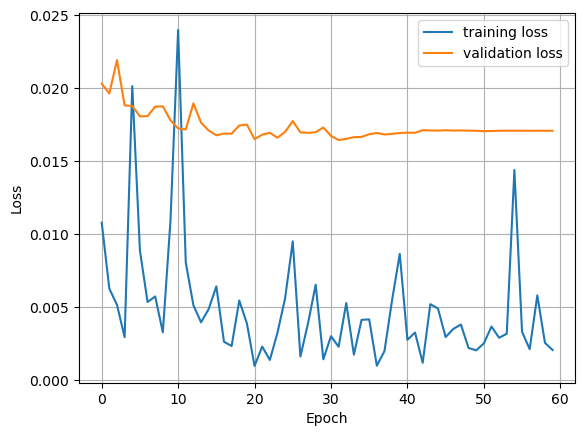

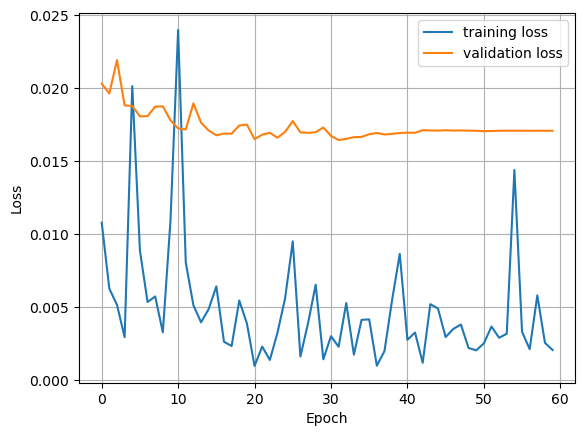

In [15]:
plt.plot(train_losses, label='training loss')
plt.plot(validation_losses, label='validation loss')
plt.legend();
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [16]:
stop

NameError: name 'stop' is not defined

NameError: name 'stop' is not defined

In [18]:
# Rename it !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# torch.save(ModelCutter.state_dict(), 'Modele/Small_UN2-60E.pt')

In [36]:
device='cuda'
Model= smp.Unet(in_channels=3, classes=1,encoder_weights=None,encoder_name='timm-resnest50d').to(device)
Model.load_state_dict(torch.load('Modele/Small_UN1_60Epoch.pt'))
Model.eval()

ModelCutter.load_state_dict(torch.load('Modele/Small_UN2-60E.pt'))
ModelCutter.eval()

Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Check model

In [37]:
inv_resize = transforms.Resize([480,640], interpolation=transforms.InterpolationMode.NEAREST)

In [38]:
from Libraries import RANSAC
val_err = []


with torch.no_grad():
    for b, (images, true_mask) in enumerate(val_loader):
#         Apply the model
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        
        seg_ax = Model(images)
        seg_ax = F.threshold(seg_ax, 1, 0)
        images_connected = torch.cat((images, seg_ax), axis=1)
        
        mask_pred = ModelCutter(images_connected)
        mask_pred = F.threshold(mask_pred, 1, 0)
        
        for j in range(mask_pred.shape[0]):
            
            regressor = RANSAC.RANSAC(model=RANSAC.LinearRegressor(), 
                          loss=RANSAC.square_error_loss, 
                          metric=RANSAC.mean_square_error, )
            
#             err = criterion(mask_pred[j], true_mask[j])
#             val_err.append(err.cpu().detach().numpy())
            
            images_buff = inv_resize(images[j])
            RGB_buff = images_buff[0].cpu().numpy()*255
#             print(RGB_buff.shape)
#             RGB_buff = np.transpose(RGB_buff, (1,2,0))
            RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

            DEPTH_buff = images_buff[1].cpu().numpy()*5500
            trueAxis_buff = inv_resize(true_mask[j]).cpu().detach().numpy().transpose(1,2,0)
            predAxis_buff = inv_resize(mask_pred[j]).cpu().detach().numpy().transpose(1,2,0)
            
            
            PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
            PC_realAxis = CreateAxisCloud(trueAxis_buff)
            PC_predAxis = CreateAxisCloud(predAxis_buff)

            test = inv_resize(mask_pred[j]).cpu().detach().numpy().transpose(1,2,0)
            
            elo = test.flatten()
            elo = elo[np.nonzero(elo)]

            t = np.arange(elo.shape[0])
            X = t.reshape(-1,1)
            y = elo.reshape(-1,1)
            
            real = inv_resize(true_mask[j]).cpu().detach().numpy().transpose(1,2,0)
            eloR = real.flatten()
            eloR = eloR[np.nonzero(eloR)]
            tR = np.arange(eloR.shape[0])
            XR = tR.reshape(-1,1)
            yR = eloR.reshape(-1,1)
            
            regressor.fit(X, y)
#             fig, ax = plt.subplots(1, 1)
#             ax.set_box_aspect(1)
#             plt.scatter(X, y)
#             plt.plot(XR,yR, '-g')
            
            line = np.linspace(0, X.shape[0], num=X.shape[0]).reshape(-1, 1)
            # test_complete = test_complete[np.nonzero(test_complete)].flatten().reshape(-1, 1)
            
            test[np.nonzero(test)] = regressor.predict(line).reshape(1, -1)
            
#             plt.plot(line, regressor.predict(line), c="r")
            elo1 = test.flatten()
            elo1 = elo1[np.nonzero(elo1)]
            
            err = criterion(torch.Tensor(test), torch.Tensor(trueAxis_buff))
            val_err.append(err.cpu().detach().numpy())

#             plt.figure()
#             t1 = np.arange(elo1.shape[0])
#             plt.scatter(t1, elo1)
            
#             PC_RANSAC = CreateAxisCloud(test)
#             o3d.visualization.draw_geometries([PC_object,PC_RANSAC])

#             plt.figure()
#             plt.imshow(trueAxis_buff)
    
#             plt.figure()
#             plt.imshow(seg_ax[j].cpu().detach().numpy().transpose(1,2,0))
#             plt.show()
            
#             plt.figure()
#             plt.imshow(predAxis_buff)
#             plt.show()
#             print('------------------------------------------------------------')

In [39]:
np.mean(val_err)

0.011214965

In [40]:
np.std(val_err)

0.02179783

# Foty do pracy

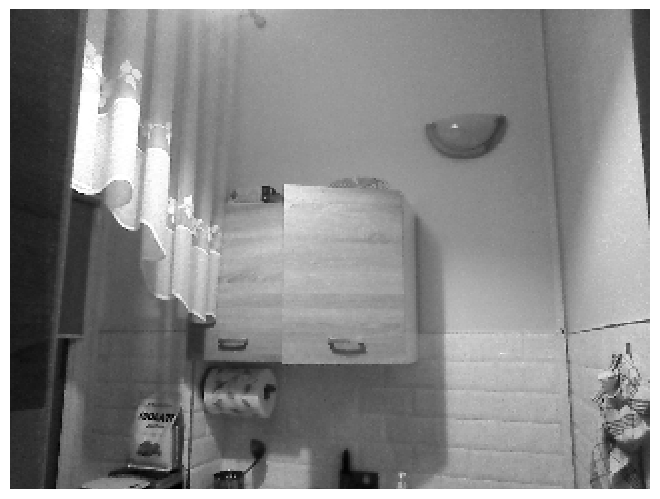

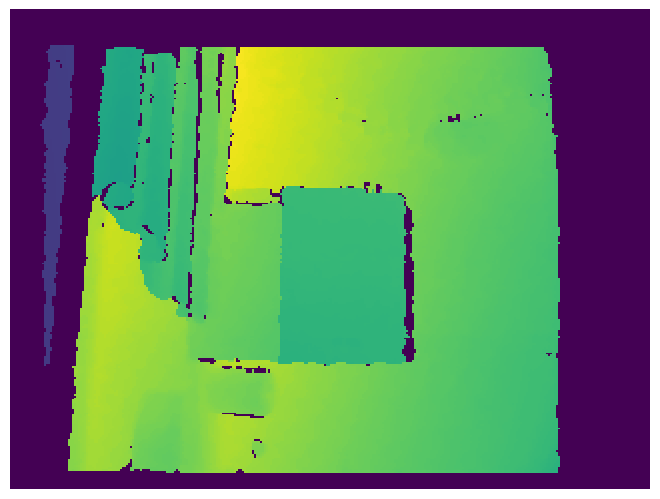

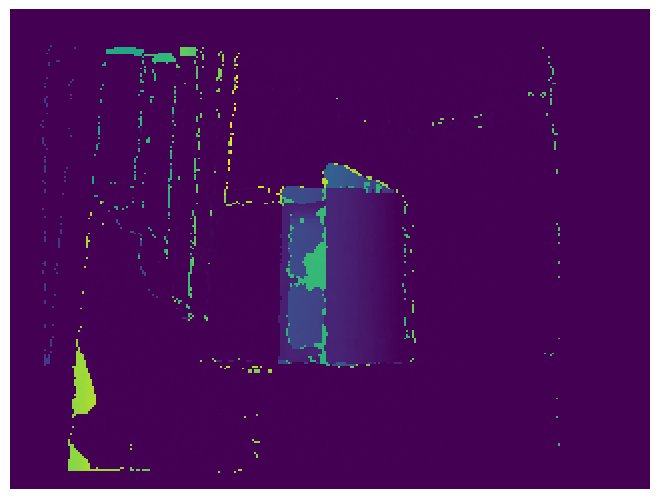

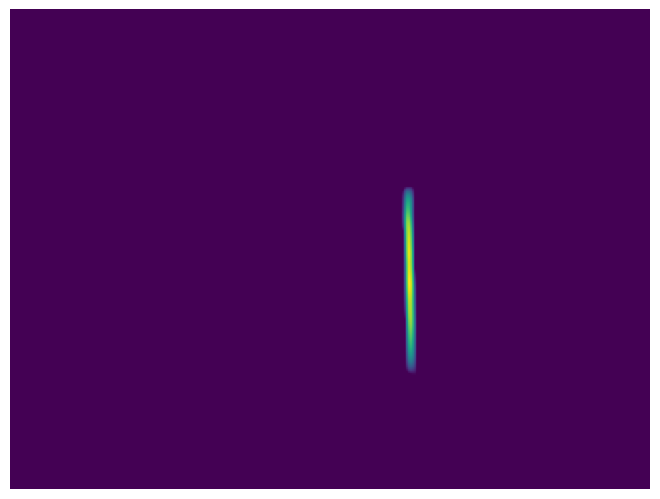

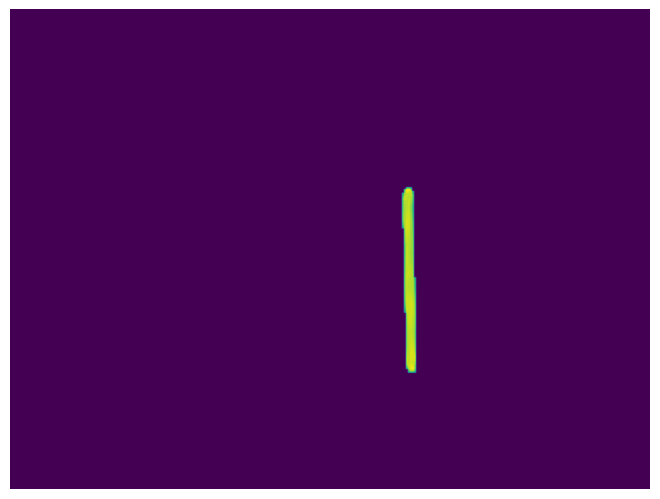

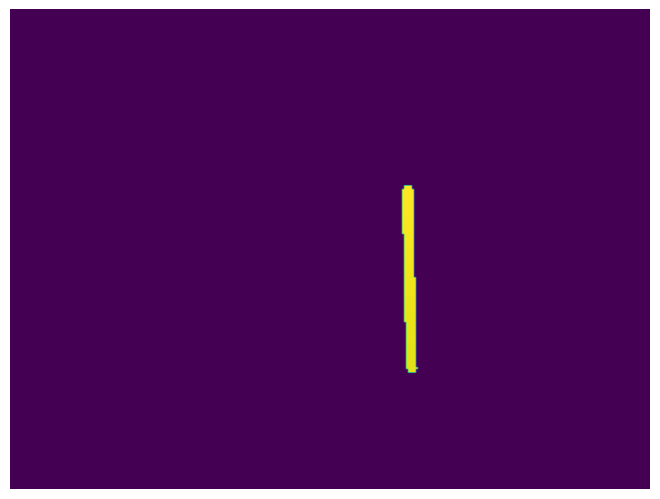

In [39]:
# aaa
Model.eval()
ModelCutter.eval()

num = 6 #6 8 11 19 30 #1 8 12 23 31
One_photo_x = X_validation[num].reshape(1,
                                      X_validation[num].shape[0],
                                      X_validation[num].shape[1],
                                      X_validation[num].shape[2]
                                     ).to(device)

One_photo_y = y_validation[num].reshape(1,
                                      y_validation[num].shape[0],
                                      y_validation[num].shape[1],
                                      y_validation[num].shape[2]
                                     ).to(device)

# One_photo_x = X_test[num].reshape(1,
#                                       X_test[num].shape[0],
#                                       X_test[num].shape[1],
#                                       X_test[num].shape[2]
#                                      ).to(device)

# One_photo_y = y_test[num].reshape(1,
#                                       y_test[num].shape[0],
#                                       y_test[num].shape[1],
#                                       y_test[num].shape[2]
#                                      ).to(device)

with torch.no_grad():
    seg2D = Model(One_photo_x)
    seg2D = F.threshold(seg2D, 1, 0)
    
    imag = torch.cat((One_photo_x, seg2D), axis=1)
    
    seg3D = ModelCutter(imag)
    seg3D = F.threshold(seg3D, 1, 0)

images_buff = inv_resize(One_photo_x[0])
RGB_buff = images_buff[0].cpu().numpy()*255
RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

DEPTH_buff = images_buff[1].cpu().numpy()*5500
trueAxis_buff = inv_resize(seg2D[0]).cpu().detach().numpy().transpose(1,2,0)
predAxis_buff = inv_resize(seg3D[0]).cpu().detach().numpy().transpose(1,2,0)

#             NEW_DEPTH = DEPTH_buffq

def SaveFig(input, path, cmap=None):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(input, aspect='auto',cmap=cmap)
    plt.show()
    fig.savefig(path, format='png')
    
# IMG_path = '/home/el_zlociako/Documents/Praca_inzynierska/CNN/Ploty_do_inz/' 

SaveFig(images_buff[0].cpu().numpy(), IMG_path+f'ST_gray_{num}.png',cmap='gray')
SaveFig(images_buff[1].cpu().numpy(), IMG_path+f'ST_depth_{num}.png',)
SaveFig(images_buff[2].cpu().numpy(), IMG_path+f'ST_depthMinus_{num}.png',)
SaveFig(seg2D[0].cpu().detach().numpy().transpose(1,2,0), IMG_path+f'ST_U1_{num}.png')
SaveFig(seg3D[0].cpu().detach().numpy().transpose(1,2,0), IMG_path+f'ST_U2_{num}.png')
SaveFig(One_photo_y[0].cpu().detach().numpy().transpose(1,2,0), IMG_path+f'ST_GT_{num}.png')
# np.save('Images/test_seg.npy', seg3D[0].cpu().detach().numpy().transpose(1,2,0))

# RANSAC

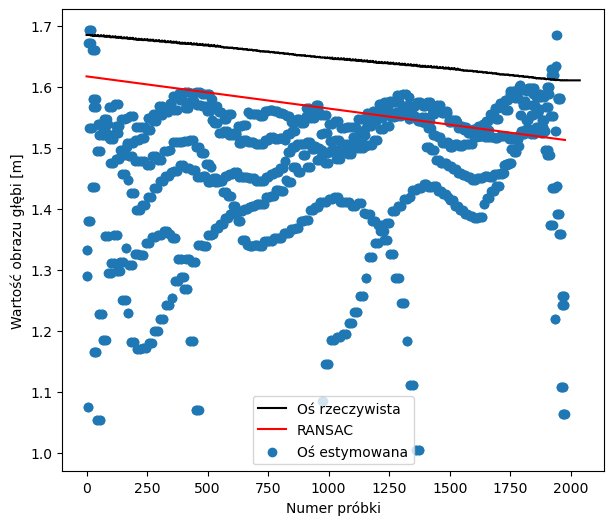

tensor(0.0006)


In [42]:
from Libraries import RANSAC


regressor = RANSAC.RANSAC(model=RANSAC.LinearRegressor(), 
                          loss=RANSAC.square_error_loss, 
                          metric=RANSAC.mean_square_error, )

test = inv_resize(seg3D[0]).cpu().detach().numpy().transpose(1,2,0)
elo = test.flatten()
elo = elo[np.nonzero(elo)]

t = np.arange(elo.shape[0])
X = t.reshape(-1,1)
y = elo.reshape(-1,1)
regressor.fit(X, y)

real = inv_resize(One_photo_y[0]).cpu().detach().numpy().transpose(1,2,0)
eloR = real.flatten()
eloR = eloR[np.nonzero(eloR)]
tR = np.arange(eloR.shape[0])
XR = tR.reshape(-1,1)
yR = eloR.reshape(-1,1)

line = np.linspace(0, X.shape[0], num=X.shape[0]).reshape(-1, 1)

# test_complete = test_complete[np.nonzero(test_complete)].flatten().reshape(-1, 1)
test[np.nonzero(test)] = regressor.predict(line).reshape(1, -1)

plt.figure(figsize=(7, 6))
plt.scatter(X, y)
plt.plot(XR, yR, '-k')
plt.plot(line, regressor.predict(line), c="r")
plt.xlabel('Numer próbki')
plt.ylabel('Wartość obrazu głębi [m]')
plt.legend(['Oś rzeczywista','RANSAC','Oś estymowana'])
# plt.savefig(f'/home/el_zlociako/Documents/Praca_inzynierska/CNN/Ploty_do_inz/BT_RANSAC_{num}.eps', format='eps',bbox_inches='tight')

elo1 = test.flatten()
elo1 = elo1[np.nonzero(elo1)]

t1 = np.arange(elo1.shape[0])
# plt.imshow(One_photo_y[0].cpu().detach().numpy().transpose(1,2,0))
plt.show()
Y_buff = inv_resize(One_photo_y[0]).cpu().detach().numpy().transpose(1,2,0)
print(criterion(torch.Tensor(test), torch.Tensor(Y_buff)))
# print(Y_buff.shape)


In [43]:
PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
PC_RANSAC = CreateAxisCloud(test)
PC_realAxis = CreateAxisCloud(Y_buff)
PC_predAxis = CreateAxisCloud(inv_resize(seg3D[0]).cpu().detach().numpy().transpose(1,2,0))

o3d.visualization.draw_geometries([PC_object, PC_realAxis])
o3d.visualization.draw_geometries([PC_object, PC_predAxis])
o3d.visualization.draw_geometries([PC_object,PC_RANSAC])